$$ \LaTeX \text{ command declarations here.}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\D}{\mathcal{D}}
\newcommand{\G}{\mathcal{G}}
\newcommand{\L}{\mathcal{L}}
\newcommand{\X}{\mathcal{X}}
\newcommand{\Parents}{\mathrm{Parents}}
\newcommand{\NonDesc}{\mathrm{NonDesc}}
\newcommand{\I}{\mathcal{I}}
\newcommand{\dsep}{\text{d-sep}}
\newcommand{\Cat}{\mathrm{Cat}}
\newcommand{\Bin}{\mathrm{Bin}}
$$

In [9]:
from __future__ import division

# scientific
%matplotlib inline
from matplotlib import pyplot as plt;
import matplotlib as mpl;
import numpy as np;
import sklearn as skl;
import sklearn.datasets;
import sklearn.cluster;
import sklearn.mixture;

# ipython
import IPython;

# python
import os;
import random;

#####################################################

# image processing
import PIL;

# trim and scale images
def trim(im, percent=100):
    print("trim:", percent);
    bg = PIL.Image.new(im.mode, im.size, im.getpixel((0,0)))
    diff = PIL.ImageChops.difference(im, bg)
    diff = PIL.ImageChops.add(diff, diff, 2.0, -100)
    bbox = diff.getbbox()
    if bbox:
        x = im.crop(bbox)
        return x.resize(((x.size[0]*percent)//100, (x.size[1]*percent)//100), PIL.Image.ANTIALIAS);


#####################################################

# daft (rendering PGMs)
import daft;

# set to FALSE to load PGMs from static images
RENDER_PGMS = True;

# decorator for pgm rendering
def pgm_render(pgm_func):
    def render_func(path, percent=100, render=None, *args, **kwargs):
        print("render_func:", percent);
        # render
        render = render if (render is not None) else RENDER_PGMS;
        
        if render:
            print("rendering");
            # render
            pgm = pgm_func(*args, **kwargs);
            pgm.render();
            pgm.figure.savefig(path, dpi=300);
            
            # trim
            img = trim(PIL.Image.open(path), percent);
            img.save(path, 'PNG');
        else:
            print("not rendering");
        
        # error
        if not os.path.isfile(path):
            raise Exception("Error:  Graphical model image %s not found.  You may need to set RENDER_PGMS=True." % path);
        
        # display
        return IPython.display.Image(filename=path);#trim(PIL.Image.open(path), percent);
    
    return render_func;

######################################################

# EECS 545:  Machine Learning

## Lecture 16:  Clustering, Mixture Models, and EM

- Instructor:  **Jacob Abernethy**
- Date:  March 14, 2016

*Lecture Exposition:*  Benjamin Bray

# This lecture has notes!

> See Canvas / GitHub

## References

- **[MLAPP]** Murphy, Kevin. [*Machine Learning:  A Probabilistic Perspective*](https://mitpress.mit.edu/books/machine-learning-0).  2012.
- **[PRML]** Bishop, Christopher.  [*Pattern Recognition and Machine Learning*](http://research.microsoft.com/en-us/um/people/cmbishop/prml/).  2006.
- **[Koller & Friedman 2009]** Koller, Daphne and Nir Friedman.  [*Probabilistic Graphical Models*](https://mitpress.mit.edu/books/probabilistic-graphical-models).  2009.
- **[Neal & Hinton 1998]** Neal, Radford and Geoffrey Hinton.  ["A View of the EM Algorithm that Justifies Incremental, Sparse, and Other Variants"](http://www.cs.toronto.edu/~fritz/absps/emk.pdf).  1998.
- **[Do 2008]** Do, Chuong B. and Serafim Batzoglou.  ["What is the Expectation Maximization Algorithm?"](http://www.nature.com/nbt/journal/v26/n8/full/nbt1406.html). 2008.

## Outline

- Clustering & Mixture Models
    - Latent Variable Models
    - Gaussian Mixture Models
- Review:  Information Theory
- Expectation Maximization
    - Evidence Lower Bound
    - Variational Approximation
- Examples
    - Coin Flip Example
    - Gaussian Mixture Models

# Clustering & Mixture Models

> Uses material from **[MLAPP]**

### Review:  Latent Variable Models

In a **Latent Variable Model**, we have
- Observed variables $X$
- Hidden variables $Z$ that influence $X$
- Parameters $\theta$ governing the overall model

In general, our goal is to
> Use what we know to make *inferences* about what we don't know.

### Review:  Latent Variable Models

The most general latent variable model for iid observations $\X$ is
- $X_n$ and $Z_n$ may be sets of variables
- Parameters $\theta$ can be divided into variables $\theta_x$ influencing $X$ and $\theta_z$ influencing $Z$

In [3]:
@pgm_render
def pgm_latent():
    pgm = daft.PGM([4,4], origin=[-2,-1], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("z", r"$Z_n$", 0.7, 1));
    pgm.add_node(daft.Node("x", r"$X_n$", 1.3, 1, observed=True));
    pgm.add_node(daft.Node("theta", r"$\theta$", 1.3, 0.3));
    
    # edges
    pgm.add_edge("z", "x", head_length=0.08);
    pgm.add_edge("theta", "x", head_length=0.08);
    pgm.add_edge("theta", "z", head_length=0.08);
    
    pgm.add_plate(daft.Plate([0.4,0.8,1.3,0.5], label=r"$\qquad\qquad\qquad\;\; N$",
    shift=-0.1))
    
    return pgm;

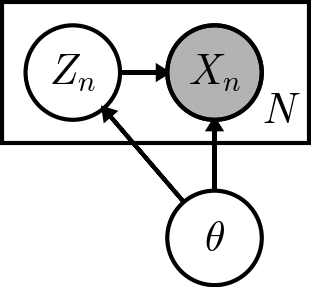

In [4]:
%%capture
pgm_latent("images/pgm/latent.png")

### Review:  Clustering

**Goal:** Partition data $\X = \{ x_1, \dots, x_n \} \subset \R^d$ into $K$ disjoint **clusters**.
- Points within a cluster should be more similar to each other than to points in other clusters.
- Estimate **cluster centers** $\mu_k \in \R^d$ for $k=1,\dots,K$
- Estimate **cluster assignments** $z_j \in \{1,\dots,K\}$ for each point $x_j$

Usually, we fix $K$ beforehand!  Use model selection to overcome this limitation.

### Review:  K-Means Clustering

First, pick random cluster centers $\mu_k$.  Then, repeat until convergence:

<div style="margin:10px; padding: 10px; border: 2px solid black">
**E-Step:** Assign $x_j$ to the nearest cluster center $\mu_k$,
$$
z_j = \arg\min_k || x_j - \mu_k ||^2
$$

**M-Step:** Re-estimate cluster centers by averaging over assignments:
$$
\mu_k = \frac{1}{ \# \{ j \mid z_j =k \}} \sum_{j=1}^N x_j \mathbb{I}(z_j = k)
$$
</div>

### Mixture Models

Clustering problems motivate the definition of a **mixture model**.
- Observe data from multiple **base distributions** $p_k(x|\theta_k)$ over the same space.
- Proportion of each distribution given by **mixing weights** $\pi = (\pi_1,\dots,\pi_K)$
- Don't know *which* distribution each point comes from.

$$
p(x | \theta) = \sum_{k=1}^K \pi_k p_k(x | \theta_k)
$$

### Mixture Models for Clustering

In clustering, we represent mixtures via latent **cluster indicators**,
$$
\begin{align}
z_n &\sim \Cat[\pi] & \forall\, n = 1,\dots,N \\
x_n \mid z_n &\sim p_k(\cdot \mid \theta_{z_n}) & \forall\, n = 1,\dots,N
\end{align}
$$

In this form, mixture models are clearly applicable to clustering problems.

> For a deeper understanding of mixture models, see [De Finetti's Theorem](http://www.cs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture1.pdf).

### Gaussian Mixture Models

In a **Gaussian Mixture Model**, the base distributions are Gaussian.
- Cluster $k$ has mean $\mu_k$, covariance $\Sigma_k$

$$
\begin{align}
z_n &\sim \Cat[\pi] & \forall\, n = 1,\dots,N \\
x_n \mid z_n &\sim \mathcal{N}(\mu_{z_n}, \Sigma_{z_n}) & \forall\, n = 1,\dots,N
\end{align}
$$


### Gaussian Mixture Models:  Visualization

Here are the contours of each base distribution plotted together:

In [14]:
# example stolen from scikit-learn docs
def plot_gmm():
    n_samples = 300

    # generate random sample, two components
    np.random.seed(0)

    # generate spherical data centered on (20, 20)
    shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

    # generate zero centered stretched Gaussian data
    C = np.array([[0., -0.7], [3.5, .7]])
    stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

    # concatenate the two datasets into the final training set
    X_train = np.vstack([shifted_gaussian, stretched_gaussian])

    # fit a Gaussian Mixture Model with two components
    clf = skl.mixture.GMM(n_components=2, covariance_type='full')
    clf.fit(X_train)

    # display predicted scores by the model as a contour plot
    x = np.linspace(-20.0, 30.0)
    y = np.linspace(-20.0, 40.0)
    X, Y = np.meshgrid(x, y)
    XX = np.array([X.ravel(), Y.ravel()]).T
    Z = -clf.score_samples(XX)[0]
    Z = Z.reshape(X.shape)
    
    plt.figure(figsize=(10,8))
    CS = plt.contour(X, Y, Z, norm=mpl.colors.LogNorm(vmin=1.0, vmax=1000.0),
                     levels=np.logspace(0, 3, 10))
    CB = plt.colorbar(CS, shrink=0.8, extend='both')
    plt.scatter(X_train[:, 0], X_train[:, 1], .8)

    plt.title('Negative log-likelihood predicted by a GMM')
    plt.axis('tight')

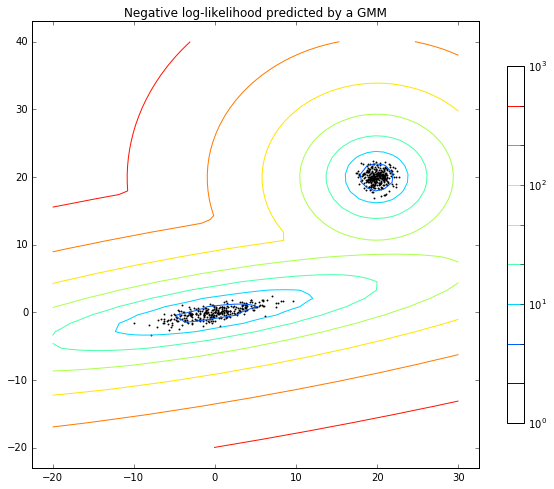

In [15]:
plot_gmm()

### Gaussian Mixture Models:  Inference & Learning

**Goal:** Since only the data points $x_n$ are observed, we wish to
1. Learn the cluster parameters $\mu$, $\Sigma$
2. Infer the cluster assignments $z_n$ for each point $x_n$

We will use the **Expectation Maximization** algorithm.
- Same general idea as K-means, but *fuzzier* (probabilistic!)
- Alternate between *guessing* latent variables and *re-estimating* parameters.

# Review of Information Theory
> See **Lecture 13** or **[MLAPP]** §2.8 for more details.

### Review:  Entropy

The **entropy** of a discrete random variable $X$ with distribution $p$ is
$$
H[X] = H[p] = E[I(p(X))] = - \sum_{x \in X} p(x) \log p(x)
$$

Entropy measures the **optimal code length**, in bits, for messages drawn from $p$.
- Expected information received when sampling from $X$.

### Review:  Cross Entropy

The **cross entropy** measures the average number of bits needed to encode messages drawn from $p$ when we use a code optimal for $q$:
$$
H(p,q) = -\sum_{x \in \X} p(x) \log q(x)
= - E_p[\log q(x)]
$$

Intuitively, $H(p,q) \geq H(p)$.  The **relative entropy** is the difference $H(p,q) - H(p)$.

### Review:  Relative Entropy

The **relative entropy** or **Kullback-Leibler divergence** of $q$ from $p$ is

$$
\begin{align}
D_{KL}(p || q)
&= \sum_{x \in X} p(x) \log \frac{p(x)}{q(x)} \\
&= H(p,q) - H(p)
\end{align}
$$

> Measures the number of *extra* bits needed to encode messages from $p$ if we use a code optimal for $q$.

# Expectation Maximization

> Uses material from **[Neal & Hinton 1998]**, **[Do 2008]**, and **[MLAPP]**

### Theoretical Perspective

Most textbooks (including **[MLAPP]** and **[PRML]**) introduce EM without much justification.
- This is confusing and unsatisfying!

Instead, we will tackle the theory head-on, using ideas from **[Neal & Hinton 1998]**.

> **Question:** How can we perform maximum likelihood estimation in latent variable models?

### Parameter Estimation with Latent Variables

> **Question:**  How can we perform MLE/MAP in latent variable models?

In [ ]:
%%capture
pgm_latent("images/pgm/latent.png")

### Complete Data Log-Likelihood

Suppose we observe both $X$ and $Z$.  The **complete data log-likelihood** is
$$
\ell_c(\theta)
= P(X,Z | \theta)
= \sum_{n=1}^N \log p(x_n, z_n | \theta)
$$

> **[MLAPP]:** This likelihood function is convex when $p(x_n,z_n | \theta)$ is an exponential family distribution.

### Observed Data Log-Likelihood

In reality, we only observe $\X=(x_1,\dots,x_n)$.  The **observed data log-likelihood** is given by 
$$
\begin{align}
\ell(\theta | \X) 
&= \log p(\X | \theta)
= \sum_{k=1}^N \log p(x_k | \theta) \\
&= \sum_{k=1}^N \left[ \log \sum_{z_k} p(x_k, z_k | \theta) \right]
\end{align}
$$

> **[MLAPP]:** This likelihood function is **non-convex** even assuming exponential family distributions.  Multiple modes make inference (NP) hard!

### Wrangling a Non-Convex Likelihood

How can we optimize the observed likelihood $\ell(\theta|\X)$?
- *Gradient-based methods?* Tricky to enforce constraints (e.g. positive-definiteness)

> We need a different approach...

### Wrangling a Non-Convex Likelihood

**Observation:** In most models, MLE/MAP is easy with fully observed data.  We will alternate between
- **E-Step:** Inferring the values of the latent variables.
- **M-Step:** Re-estimating the parameters, assuming we have complete data.

> Note the similarity to K-Means!

### Optimizing via Lower-Bounds

From a theoretical standpoint, we will alternate between
1. Estimating a lower bound $\L(q,\theta)$ on $\log p(\X|\theta)$
2. Maximizing this lower bound to obtain a new estimate of $\theta$

<img src="images/bishop-fig914-em-bound.png">
<span style="color: gray">(Figure 9.14 of **[PRML]**)</span>

### Expectation Maximization

Our general approach will be to reason about the hidden variables through a proxy distribution $q(Z)$.
- Distribution $q$ is an approximation to $P(Z | \X, \theta)$
- We use $q$ to compute a lower bound on the log-likelihood.

> The $q$ distribution will disappear later, but this perspective is useful for extending EM to new settings.

### Review:  Jensen's Inequality

For a convex function $f$, 
$$
\sum_{k=1}^K \lambda_k f(x_k) \geq f\left( \sum_{k=1}^K \lambda_k x_k \right)
$$

If $\lambda_k \geq 0$ and $\sum_{k=1}^K \lambda_k = 1$.

### Evidence Lower Bound

Through Jensen's inequality, we obtain the **evidence lower bound (ELBO)** on the log-likelihood:
$$
\begin{align}
\ell(\theta | \X)
&= \log \sum_z p(\X, z | \theta) \\
&= \log \sum_z q(z) \frac{p(\X, z | \theta)}{q(z)} \\
&\geq \sum_z q(z) \ln \frac{p(\X, z | \theta)}{q(z)} \equiv \L(q, \theta)
\end{align}
$$

### Evidence Lower Bound

We can rewrite the lower bound $\L(q, \theta)$ as follows:
$$
\begin{align}
\ell(\theta | \X)
\geq \L(q,\theta)
&= \sum_z q(z) \log \frac{p(\X,z|\theta)}{q(z)} \\
&= \sum_q q(z) \log p(\X,z|\theta) - \sum_z q(z) \log q(z) \\
&= E_q[\log p(\X,Z|\theta)] - E_q[\log q(z)] \\
&= E_q[\log p(\X,Z|\theta)] + H[q]
\end{align}
$$

### ELBO:  Relationship to Relative Entropy

We have just shown that
$$
\ell(\theta|\X) \geq \L(q,\theta)
= E_q[\log p(\X,Z|\theta)] - E_q[\log q(z)]
$$

This very closely resembles the formula for **relative entropy** 
$$
\begin{align}
D_{KL}(q || p) 
&= E_q[-\log p(Z)] + E_q[\log q(Z)] \\
&= H[q,p] - H[q]
\end{align}
$$

Except that the variables $X$ are clamped to our observations $X=\X$.
- So $P(\X,Z)$ is an *unnormalized* distribution.

### ELBO:  Relationship to Relative Entropy

It is easy to show $\L(q,\theta)$ differs from a relative entropy by only a constant wrt $\theta$:
$$
\begin{align*}
D_{KL}(q || p(Z|\X,\theta))
&= H(q, p(Z|\X,\theta)) - H(q) \\
&= E_q[ -\log p(Z|\X,\theta) ] - H(q) \\
&= E_q[ -\log p(Z,\X | \theta) ] - E_q[ -\log p(\X|\theta) ] - H(q) \\
&= E_q[ -\log p(Z,\X | \theta) ] + \log p(\X|\theta) - H(q) \\
&= -\mathcal{L}(q,\theta) + \mathrm{const.}
\end{align*}
$$

### ELBO:  Tightness

This yields a second proof of the ELBO, since $D_{KL} \geq 0$,
$$
\boxed{
\log p(\X | \theta)
= D_{KL}(q || p(Z | \X, \theta)) + \mathcal{L}(q,\theta) 
\geq \mathcal{L}(q,\theta)
}
$$

The quality of our bound $\L(q,\theta)$ depends heavily on the choice of proxy distribution $q(Z)$.

> **Remark:** Maximizing $\L(q, \theta)$ with respect to $q$ is equivalent to minimizing the relative entropy between $q$ and the hidden posterior $P(Z|\X,\theta)$.  Hence, the optimal $q$ is exactly the hidden posterior, for which $\log p(\X|\theta) = \L(q,\theta)$.

The bound is **tight**--we can make it *touch* the log-likelihood.

### Expectation Maximization

Finding a global maximum of the likelihood is difficult in the presence of latent variables.
$$
\hat\theta_{ML} = \arg\max_\theta \ell(\theta | \X) = \arg\max_\theta \log p(\X|\theta)
$$

Instead, the **Expectation Maximization** algorithm gives an iterative procedure for finding a *local* maximum of the likelihood.
- Under the assumption that the hidden posterior $P(Z|\X,\theta)$ is tractable.
- Exploits the evidence lower bound $\ell(\theta|\X) \geq \L(q,\theta)$.

### Expectation Maximization

Consider only proxy distributions of the form
$$
q_\vartheta(Z) = p(Z | \X, \vartheta)
$$

The optimal value for $\vartheta$, in the sense that $\L(\vartheta, \theta) \equiv \L(q_\vartheta, \theta)$ is maximum, depends on $\theta$.
- Similarly, the optimal $\theta$ depends on $\vartheta$.

This suggests an *iterative* scheme.

### Expectation Maximization:  E-Step

Suppose we have an estimate $\theta_t$ of the parameters.  To improve our estimate, we first compute a new lower bound on the observed log-likelihood,
$$
\vartheta_{t+1}
= \arg\max_\vartheta \L(\vartheta, \theta_t)
= \theta_t
$$

Since $q_\vartheta(Z) = p(Z|\X,\vartheta)$, we know from before that $\vartheta=\theta_t$ maximizes $\L(\vartheta, \theta)$.

### Expectation Maximization:  M-Step

Next, we estimate new parameters by optimizing over the lower bound.
$$
\begin{align}
\theta_{t+1}
&= \arg\max_\theta \L(\vartheta_{t+1}, \theta) \\
&= \arg\max_\theta E_q[\log p(\X,Z|\theta)] - E_q[\log q_\vartheta(z)] \\
&= \arg\max_\theta E_q[ \log p(\X,Z | \theta) ]
\end{align}
$$

The last line optimizes over the **expected complete data log-likelihood**.

### Expectation Maximization:  Algorithm

Expectation maximization performs **coordinate ascent** on $\L(\vartheta,\theta)$.

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Compute a new lower bound on the observed log-likelihood,
    $$
    \vartheta_{t+1} 
    = \arg\max_\vartheta \L(\vartheta, \theta_t)
    = \theta_t
    $$
</div><div>
**M-Step:** Estimate new parameters by maximizing the bound.
    $$
    \theta_{t+1}
    = \arg\max_\theta \L(\vartheta_{t+1}, \theta)
    = \arg\max_\theta E_q[ \log p(\X,Z | \theta) ]
    $$
</div>
</div>

### Expectation Maximization:  Standard Formulation

Some authors define the **auxiliary function** or **Q-function**
$$
Q(\theta_t, \theta) = E_q[\log p(\X,Z|\theta)]
$$
where $q(Z) = p(Z|\X,\theta_t)$ as before.

> Some forgo the $q$ function altogether!

### Expectation Maximization:  Standard Formulation

Expectation maximization performs updates on $Q(\theta_t,\theta)$.

<div style="margin:10px;padding:10px;border:2px solid black;">
<div>
**E-Step:** Write down an expression for 
    $$
    Q(\theta_t, \theta) = E_q[ \log p(\X,Z | \theta) ]
    $$
</div><div>
**M-Step:** Maximize the auxiliary function,
    $$
    \theta_{t+1}
    = \arg\max_\theta Q(\theta_t, \theta)
    $$
</div>
</div>

### Expectation Maximization:  Convergence

**Theorem:** *After a single iteration of Expectation Maximization, the observed data likelihood of the parameters has not decreased, that is,*
    $$
    \ell(\theta_t | \X) \leq \ell(\theta_{t+1} | \X)
    $$
    
*Proof:*  This result is a simple consequence of all our hard work so far!
    $$
    \begin{align}
    \ell(\theta_t | \X)
    &= \mathcal{L}(q_{\vartheta_{t+1}}, \theta_t)           
        & \text{(Tightness)} \\
    &\leq \mathcal{L}(q_{\vartheta_{t+1}}, \theta_{t+1})  
        & \text{(M-Step)} \\
    &\leq \ell(\theta_{t+1} | \X)                         
        & \text{(ELBO)}
    \end{align}
    $$

### Expectation Maximization:  Convergence

**Theorem:** *(Neal & Hinton 1998, Thm. 2)* Every local maximum of $\L(q, \theta)$ is a local maximum of $\ell(\theta | \X)$.  

> Exercise! :)

### Expectation Maximization:  Interpretation

The graph from before should now make more sense:

<img src="images/bishop-fig914-em-bound.png">

<span style="color:gray">(Figure 9.14 from **[PRML]**)</span>

### Expectation Maximization:  Examples

We're done with the theory.  Now for some examples:
- *Today:* Coin Flip Example, Gaussian Mixture Models
- *Later:* Hidden Markov Models

We'll also generalize to new settings:
- "Hard" Expectation Maximization
- Variational Expectation Maximization

### Coin Flip:  Problem

Suppose we have two coins, each with unknown bias $\theta_A$ and $\theta_B$, and collect data in the following way:

1. Repeat for $n=1, \dots, N$:
    1. Choose a random coin $z_n$.
    2. Flip this same coin $M$ times.
    3. Record only the total number $x_n$ of heads.


### Coin Flip:  Sample Data

Below is sample data for $N=5$ and $M=10$
```
HTTTHHTHTH
HHHHTHHHHH
HTHHHHHTHH
HTHTTTHHTT
THHHTHHHTH
```

### Coin Flip:  Model

The corresponding probabilistic model is a **mixture of binomials**:
$$
\begin{align}
\theta &= (\theta_A, \theta_B)  &                       
    &&\text{fixed coin biases} \\
Z_n &\sim \mathrm{Uniform}\{A, B \}    & \forall\, n=1,\dots,N
    &&\text{coin indicators} \\
X_n | Z_n, \theta &\sim \Bin[\theta_{Z_n}, M] & \forall\, n=1,\dots,N
    &&\text{head count}
\end{align}
$$

### Coin Flip:  Graphical Model

In [ ]:
@pgm_render
def pgm_coinflip():
    pgm = daft.PGM([4,4], origin=[-2,-1], node_unit=0.8, grid_unit=2.0);
    # nodes
    pgm.add_node(daft.Node("z", r"$Z_n$", 0.7, 1));
    pgm.add_node(daft.Node("x", r"$X_n$", 1.3, 1, observed=True));
    pgm.add_node(daft.Node("theta", r"$\theta$", 1.3, 0.3));
    
    # edges
    pgm.add_edge("z", "x", head_length=0.08);
    pgm.add_edge("theta", "x", head_length=0.08);
    
    pgm.add_plate(daft.Plate([0.4,0.8,1.3,0.5], 
                             label=r"$\qquad\qquad\qquad\;\; N$",
                             shift=-0.1))
    return pgm;

In [ ]:
%%capture
pgm_coinflip("images/pgm/coinflip.png")

### Coin Flip:  Complete Data Log-Likelihood

The **complete data log-likelihood** for a single trial $(x_n,z_n)$ is
$$
\log p(x_n, z_n | \theta) = \log p(z_n) + \log p(x_n | z_n, \theta)
$$
Here, $P(z_n)=\frac{1}{2}$.  The remaining term is
$$
\begin{align} 
\log p(x_n | z_n, \theta)
&= \log \binom{M}{x_n} \theta_{z_n}^{x_n} (1-\theta_{z_n})^{M-x_n} \\
&= \log \binom{M}{x_n} + x_n \log\theta_{z_n} + (M-x_n)\log(1-\theta_{z_n})
\end{align}
$$

### Coin Flip:  Likelihood Plot

There aren't many latent variables, so we can plot $\log P(\X|\theta_A,\theta_B)$ directly!

In [ ]:
def coin_likelihood(roll, bias):
    # P(X | Z, theta)
    numHeads = roll.count("H");
    flips = len(roll);
    return pow(bias, numHeads) * pow(1-bias, flips-numHeads);

def coin_marginal_likelihood(rolls, biasA, biasB):
    # P(X | theta)
    trials = [];
    for roll in rolls:
        h = roll.count("H");
        t = roll.count("T");
        likelihoodA = coin_likelihood(roll, biasA);
        likelihoodB = coin_likelihood(roll, biasB);
        trials.append(np.log(0.5 * (likelihoodA + likelihoodB)));
    return sum(trials);

def plot_coin_likelihood(rolls, thetas=None):
    # grid
    xvals = np.linspace(0.01,0.99,100);
    yvals = np.linspace(0.01,0.99,100);
    X,Y = np.meshgrid(xvals, yvals);
    
    # compute likelihood
    Z = [];
    for i,r in enumerate(X):
        z = []
        for j,c in enumerate(r):
            z.append(coin_marginal_likelihood(rolls,c,Y[i][j]));
        Z.append(z);
    
    # plot
    plt.figure(figsize=(10,8));
    C = plt.contour(X,Y,Z,150);
    cbar = plt.colorbar(C);
    plt.title(r"Likelihood $\log p(\mathcal{X}|\theta_A,\theta_B)$", fontsize=20);
    plt.xlabel(r"$\theta_A$", fontsize=20);
    plt.ylabel(r"$\theta_B$", fontsize=20);
    
    # plot thetas
    if thetas is not None:
        thetas = np.array(thetas);
        plt.plot(thetas[:,0], thetas[:,1], '-k', lw=2.0);
        plt.plot(thetas[:,0], thetas[:,1], 'ok', ms=5.0);

In [ ]:
plot_coin_likelihood([ "HTTTHHTHTH", "HHHHTHHHHH", 
         "HTHHHHHTHH", "HTHTTTHHTT", "THHHTHHHTH"]);

### Coin Flip:  E-Step

The **E-Step** involves writing down an expression for
$$
\begin{align}
E_q[\log p(\X, Z | \theta )]                  
&= E_q[\log p(\X | Z, \theta) p(Z)] \\
&= E_q[\log p(\X | Z, \theta)] + \log p(Z) \\
\end{align}
$$

The $\log p(Z)$ term is constant wrt $\theta$, so we ignore it.
> Recall $q \equiv q_{\theta_t} = p(Z | \X,\theta_t)$

### Coin Flip:  E-Step

$$
\begin{align}
E_q[\log p(\X | Z, \theta)]
&= \sum_{n=1}^N E_q \bigg[
        x_n \log \theta_{z_n} + (M-x_n) \log (1-\theta_{z_n}) 
    \bigg] + \text{const.}
\\
&= \sum_{n=1}^N q_\vartheta(z_n=A)
    \bigg[ x_n \log \theta_A + (M-x_n) \log \theta_A \bigg] \\
&+ \sum_{n=1}^N q_\vartheta(z_n=B)
    \bigg[ x_n \log \theta_B + (M-x_n) \log \theta_B \bigg]
 + \text{const.}
\end{align}
$$

### Coin Flip:  M-Step

Let $a_n = q(z_n = A)$ and $b_n = q(z_n = B)$.  Taking derivatives with respect to $\theta_A$ and $\theta_B$, we obtain the following update rules:
$$
\theta_A = \frac{\sum_{n=1}^N a_n x_n}{\sum_{n=1}^N a_n M}
\qquad
\theta_B = \frac{\sum_{n=1}^N b_n x_n}{\sum_{n=1}^N b_n M}
$$

> **Interpretation:** For each coin, examples are *weighted* according to the probability that they belong to that coin.  Observing $M$ flips is equivalent to observing $a_n M$ *effective* flips.

### Coin Flip:  Python Code

In [ ]:
def coin_em(rolls, theta_A=None, theta_B=None, maxiter=10):
    # Initial Guess
    theta_A = theta_A or random.random();
    theta_B = theta_B or random.random();
    thetas = [(theta_A, theta_B)];
    # Iterate
    for c in range(maxiter):
        print("#%d:\t%0.2f %0.2f" % (c, theta_A, theta_B));
        # assign a coin to each trial
        heads_A, tails_A = 0,0;
        heads_B, tails_B = 0,0;
        
        for trial in rolls:
            likelihood_A = coin_likelihood(trial,theta_A);
            likelihood_B = coin_likelihood(trial,theta_B);
            p_A = likelihood_A / (likelihood_A + likelihood_B);
            p_B = likelihood_B / (likelihood_A + likelihood_B);
            heads_A += p_A * trial.count("H");
            tails_A += p_A * trial.count("T");
            heads_B += p_B * trial.count("H");
            tails_B += p_B * trial.count("T");
        # recompute thetas
        theta_A = heads_A / (heads_A + tails_A);
        theta_B = heads_B / (heads_B + tails_B);
        
    thetas.append((theta_A,theta_B));    
    return thetas, (theta_A,theta_B);

### Coin Flip:  Demo

In [ ]:
rolls = [ "HTTTHHTHTH", "HHHHTHHHHH", "HTHHHHHTHH", 
          "HTHTTTHHTT", "THHHTHHHTH" ];
thetas, _ = coin_em(rolls, 0.1, 0.3, maxiter=6);

### Coin Flip:  Plot of Convergence

In [ ]:
plot_coin_likelihood(rolls, thetas)

### Gaussian Mixture Models:  Specification

Recall from earlier the **Gaussian Mixture Model**:
$$
\begin{align}
\theta &= (\vec\pi, \vec\mu, \vec\Sigma) && \text{model parameters} \\
z_n &\sim \Cat[\pi]  && \text{cluster indicators} \\
x_n | z_n, \theta &\sim \mathcal{N}(\mu_{z_n}, \Sigma_{z_n}) && \text{base distribution}
\end{align}
$$

### GMM:  Complete Likelihood

The complete data log-likelihood for a single datapoint $(x_n, z_n)$ is
$$
\begin{align}
\log p(x_n, z_n | \theta)
&= \log \prod_{k=1}^K \pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)^{\mathbb{I}(z_n = k)} \\
&= \sum_{k=1}^K \mathbb{I}(z_n = k) \log \pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)
\end{align}
$$

### GMM:  Hidden Posterior

The hidden posterior for a single point $(x_n, z_n)$ can be found using Bayes' rule:
$$
\begin{align}
p(z_n = k | x_n, \theta)
&= \frac{P(z_n=k | \theta) p(x_n | z_n=k, \theta)}{p(x_N | \theta)} \\
&= \frac{\pi_k \mathcal{N}(x_n | \mu_k, \Sigma_k)}{\sum_{k'=1}^K \pi_{k'} \mathcal{N}(x_n | \mu_{k'}, \Sigma_{k'})}
\end{align}
$$

### GMM:  E-Step

The **expected complete likelihood** is
$$
\begin{align}
E_q[ \log p(\X,Z|\theta)]
&= \sum_{n=1}^N \sum_{k=1}^K 
        E_q\big[ \mathbb{I}(z_n = k) \big] 
        \log \pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k) \\
&= \sum_{n=1}^N \sum_{k=1}^K 
        r_{nk} \log \pi_k
 + \sum_{n=1}^N \sum_{k=1}^K 
        r_{nk} \log \mathcal{N}(x_n \mid \mu_k, \Sigma_k)
\end{align}
$$

where $r_{nk} \equiv p(z_n = k \mid x_n,\theta_t)$ is the **responsibility** that cluster $k$ takes for datapoint $x_n$ after step $t$.

### GMM:  M-Step

During the M-Step, we optimize the lower bound with respect to $\theta=(\pi,\mu,\Sigma)$.  Verify that the correct updates are
$$
\begin{gather}
\pi_k = \frac{1}{N} \sum_{n=1}^N r_{nk} = \frac{r_k}{N}
\quad
\mu_k = \frac{\sum_{n=1}^N r_{nk} x_n}{r_k}
\\
\Sigma_k = \frac{\sum_{n=1}^N r_{nk} x_n x_n^T}{r_k} - \mu_k \mu_k^T
\end{gather}
$$

where $r_k = \sum_{n=1}^N r_{nk}$ is the *effective* sample size for cluster $k$.

### General Advice for EM

1. **Specify the model.**  Identify the observed variables, hidden variables, and parameters.  Draw a graphical model.
2. **Identify relevant probabilities.**  This includes the complete data likelihood $p(X,Z|\theta)$ and hidden posterior $p(Z|X,\theta)$.
3. **Derive the E-Step.** Compute $E_q[\log p(\X,Z|\theta)]$.
4. **Derive the M-Step.** Take derivatives and set to zero, when possible.  Otherwise, gradient-based methods can be used.